In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from tensorflow import keras as K
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
tf.config.list_physical_devices('GPU')

In [2]:
#Model is Inception Net V3 pretrained on ImageNet

inception_model = K.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(200, 200, 3),
    include_top=False)

In [3]:
inception_model.trainable=False

In [4]:
x = inception_model.output
x = K.layers.GlobalMaxPooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inception_model.input, outputs=predictions)

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [9]:
train_generator = train_datagen.flow_from_directory(
        'D:/data/facefor/FaceForensics_compressed/train200',  # this is the target directory  
        batch_size=16,
        class_mode='binary',
    shuffle=True)

Found 66762 images belonging to 2 classes.


In [ ]:
val_generator = test_datagen.flow_from_directory(
        'D:/data/facefor/FaceForensics_compressed/val200',  # this is the target directory  
        batch_size=16,
        class_mode='binary')

In [ ]:
test_generator = test_datagen.flow_from_directory(
        'D:/data/facefor/FaceForensics_compressed/test200',  # this is the target directory  
        batch_size=16,
        class_mode='binary',
shuffle=False)

In [ ]:
model.fit(x=train_generator, 
    epochs=15,
    verbose=1,
    shuffle=True,
    validation_data = val_generator
)
model.save_weights('ffinception2.h5') 

In [14]:
model.evaluate(
    x=val_generator,
    verbose=1,
)

  ...
    to  
  ['...']
4899/4899 [==============================] - 395s 81ms/step - loss: -5.1543 - accuracy: 0.6958


[-5.154281998279431, 0.6958114]

In [86]:
preds = model.predict(
    x=val_generator,
    verbose=1,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

980/980 [==============================] - 63s 64ms/step


In [91]:
cm = confusion_matrix(val_generator.classes, preds_rounded)

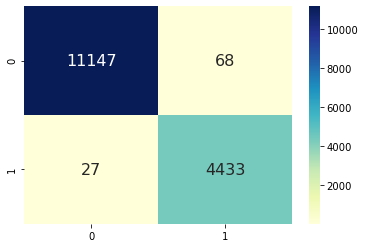

In [92]:
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",fmt="g", annot_kws={"size": 16}) # font size

plt.show()

In [93]:
print(classification_report(val_generator.classes, preds_rounded))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     11215
           1       0.98      0.99      0.99      4460

    accuracy                           0.99     15675
   macro avg       0.99      0.99      0.99     15675
weighted avg       0.99      0.99      0.99     15675



In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 99, 99, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 99, 99, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________